<a href="https://colab.research.google.com/github/carriethebear/Newbee-Project/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel('price_training.xlsx',index_col="Date")

In [3]:
df.head()

,Price
Date,
20xx-01-05,39.33
20xx-01-06,38.77
20xx-01-07,37.36
20xx-01-08,38.14
20xx-01-11,38.78


# Data Cleaning

In [4]:
# Creating Dependent Variable
# Using Last Day value
y = df.iloc[:-1].values
X = df.iloc[1:].values
MSE = mean_squared_error(X,y)
MSE

1.7743202586206896

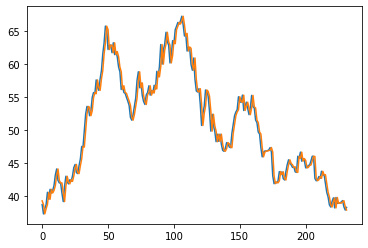

In [5]:
plt.plot(X)
plt.plot(y)
plt.show()

In [6]:
# Using 5-Day Moving Average
y = df.rolling(window=5).mean().dropna()
y = y[:-1].values
X = df.iloc[5:].values
MSE = mean_squared_error(X,y)
MSE

4.453438491228058

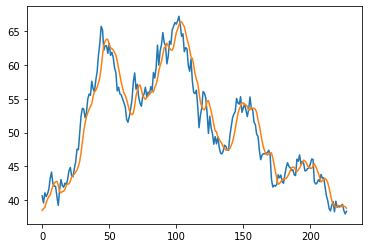

In [7]:
plt.plot(X)
plt.plot(y)
plt.show()

In [8]:
y = df.ewm(span=5,adjust=False).mean()
y = y[:-1].values
X = df[1:].values
MSE = mean_squared_error(X,y)
MSE

3.6634082003679427

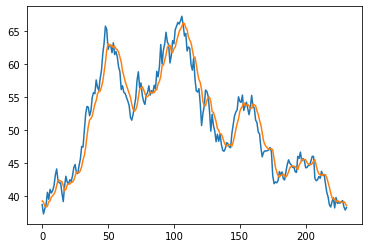

In [9]:
plt.plot(X)
plt.plot(y)
plt.show()

# Data Preparation

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df.values)
#df_scaled = pd.DataFrame(df_scaled)

In [12]:
def load_data(stock, window):
    amount_of_features = 1
    data = stock 
    sequence_length = window + 1 # index starting from 0
    result = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 
 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  
 
    return [X_train, y_train, X_test, y_test]

In [13]:
X_train, y_train, X_test, y_test = load_data(df_scaled, 22)

In [14]:
X_train.shape

(189, 22, 1)

In [15]:
y_train.shape

(189,)

# Data Cleaning New


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# log return
#df_scaled = np.diff(df.Price)

In [18]:
#min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df.values)

In [19]:
# split X
steps = 40
f = 10
X = []
y = []
data = list(df_scaled.reshape(1,233)[0])
for i in range(len(data)-steps-f+1):
  X.append(data[i:i+steps])
X = np.array(X).reshape(len(X),steps,1)


In [20]:
X.shape

(184, 40, 1)

In [21]:
# split Y
for i in range(len(data)-steps-f+1):
  y.append(data[i+steps:i+steps+f])
y = np.array(y)

In [22]:
y.shape

(184, 10)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, shuffle = False)

In [24]:
y_test

array([[0.08609715, 0.04589615, 0.03484087, 0.06231156, 0.08107203,
        0.03048576, 0.08308208, 0.05326633, 0.05628141, 0.05427136],
       [0.04589615, 0.03484087, 0.06231156, 0.08107203, 0.03048576,
        0.08308208, 0.05326633, 0.05628141, 0.05427136, 0.06097152],
       [0.03484087, 0.06231156, 0.08107203, 0.03048576, 0.08308208,
        0.05326633, 0.05628141, 0.05427136, 0.06097152, 0.06733668],
       [0.06231156, 0.08107203, 0.03048576, 0.08308208, 0.05326633,
        0.05628141, 0.05427136, 0.06097152, 0.06733668, 0.03651591],
       [0.08107203, 0.03048576, 0.08308208, 0.05326633, 0.05628141,
        0.05427136, 0.06097152, 0.06733668, 0.03651591, 0.01976549],
       [0.03048576, 0.08308208, 0.05326633, 0.05628141, 0.05427136,
        0.06097152, 0.06733668, 0.03651591, 0.01976549, 0.03283082]])

# LSTM

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Bidirectional
import math

In [26]:
d = 0.1
#layers = [1, seq_len, 1] # feature, window, output
n_steps = X_train.shape[1]
n_features = 1
neurons = [90, 20]
epochs = 300

In [27]:
# two layers
def lstm_model(d, n_steps, n_features, neurons, epochs):
  model = Sequential()

  model.add(LSTM(neurons[0],input_shape=(n_steps,1), return_sequences=True))
  model.add(Dropout(d))

  model.add(Bidirectional(LSTM(neurons[1], activation='tanh'),input_shape=(n_steps,1)))
  #model.add(Dropout(d))

  #model.add(LSTM(neurons[2],input_shape=(neurons[0],1)))
  #model.add(Dense(32))
  model.add(Dense(f))
  model.compile(loss='mse', optimizer='adam')  

  return model

In [28]:
model = lstm_model(d, n_steps, n_features, neurons, epochs)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 90)            33120     
_________________________________________________________________
dropout (Dropout)            (None, 40, 90)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                17760     
_________________________________________________________________
dense (Dense)                (None, 10)                410       
Total params: 51,290
Trainable params: 51,290
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train,y_train, 
                    validation_data=(X_test, y_test),
                    epochs=epochs,verbose=0)

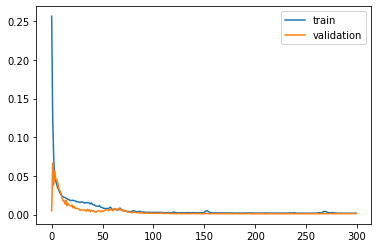

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [32]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: ', trainScore)
 
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.00161305523943156
Test Score:  0.0013428089441731572


In [33]:
trainScore = math.sqrt(trainScore)
#trainScore = math.sqrt(trainScore*(1-trainScore)/X_train.shape[0])

In [34]:
trainScore

0.040162858954904596

In [35]:
def print_pred(n):
  pred = model.predict(np.array([X_test[n]]))
  pred_up = pred + 1.282*trainScore
  pred_down = pred - 1.282*trainScore

  pred = min_max_scaler.inverse_transform(pred)
  pred_up = min_max_scaler.inverse_transform(pred_up)
  pred_down = min_max_scaler.inverse_transform(pred_down)

  test = min_max_scaler.inverse_transform(np.array([y_test[n]]))

  plt.plot(pred_down[0])
  plt.plot(pred[0])
  plt.plot(test[0])
  plt.plot(pred_up[0])
  plt.title('Prediction')
  plt.show()

  return


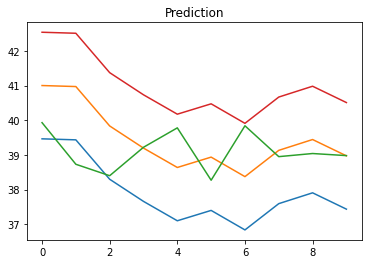

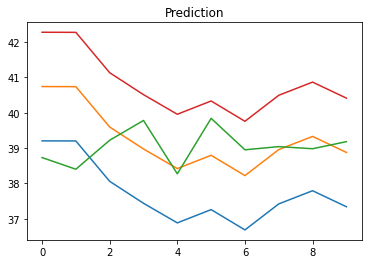

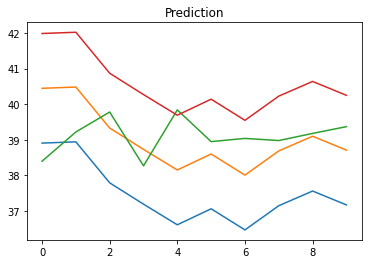

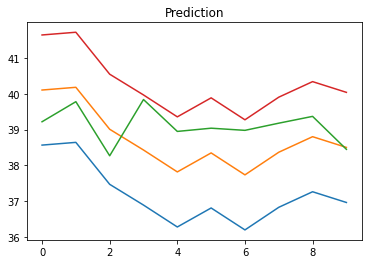

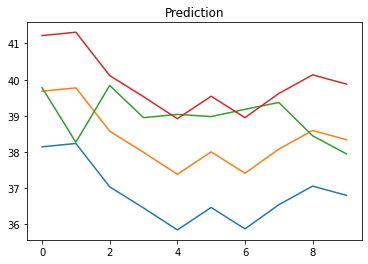

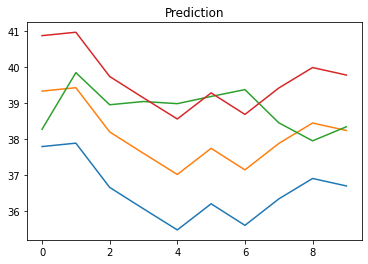

In [36]:
for i in range(X_test.shape[0]):
  print_pred(i)

In [37]:
#test

In [38]:
#pred

# Prediction


In [39]:
n = n_steps
XX = df_scaled[-n:]

In [40]:
final_X = np.array([XX])

In [41]:
final_X.shape

(1, 40, 1)

In [42]:
pred = model.predict(final_X)
pred_up = pred + 1.282*trainScore
pred_down = pred - 1.282*trainScore

pred = min_max_scaler.inverse_transform(pred)
pred_up = min_max_scaler.inverse_transform(pred_up)
pred_down = min_max_scaler.inverse_transform(pred_down)

<function matplotlib.pyplot.show>

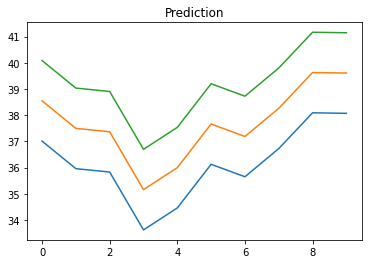

In [43]:
plt.plot(pred_down[0])
plt.plot(pred[0])
plt.plot(pred_up[0])
plt.title('Prediction')
plt.show

In [44]:
pred

array([[38.546776, 37.495365, 37.366306, 35.15802 , 35.996822, 37.661354,
        37.18653 , 38.261345, 39.626358, 39.606583]], dtype=float32)

In [45]:
pred_up

array([[40.08372 , 39.032307, 38.903248, 36.694958, 37.53376 , 39.198296,
        38.723476, 39.798286, 41.1633  , 41.143524]], dtype=float32)

In [46]:
pred_down

array([[37.00984 , 35.958427, 35.82937 , 33.62108 , 34.45988 , 36.124416,
        35.649593, 36.724407, 38.08942 , 38.06964 ]], dtype=float32)